In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random as rn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)


In [150]:
aids = pd.read_csv('data/AIDS_Classification.csv')

In [151]:
aids.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [153]:
aids.drop(columns={'z30', 'treat','str2', 'cd420','cd820'}, inplace=True)

In [154]:
aids.shape

(2139, 18)

In [155]:
aids.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,preanti,race,gender,strat,symptom,offtrt,cd40,cd80,infected
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,379.175783,0.288453,0.827957,1.979897,0.172978,0.362786,350.501169,986.627396,0.243572
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,468.657526,0.453149,0.377506,0.899053,0.378317,0.480916,118.573863,480.197750,0.429338
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,40.000000,0.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,263.500000,654.000000,0.000000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,142.000000,0.000000,1.000000,2.000000,0.000000,0.000000,340.000000,893.000000,0.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,739.500000,1.000000,1.000000,3.000000,0.000000,1.000000,423.000000,1207.000000,0.000000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,2851.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1199.000000,5011.000000,1.000000


In [156]:
aids.corr().sort_values('infected',ascending=False)['infected']

infected    1.000000
strat       0.131441
symptom     0.129234
preanti     0.128453
offtrt      0.092850
age         0.070384
cd80        0.065338
homo        0.054279
gender      0.045118
oprior      0.041251
wtkg        0.016205
hemo       -0.011154
drugs      -0.049794
race       -0.055977
trt        -0.084360
karnof     -0.102944
cd40       -0.185647
time       -0.574989
Name: infected, dtype: float64

In [157]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, original_columns):
        self.transformer = transformer
        self.original_columns = original_columns
    
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.transformer.transform(X)
        if not isinstance(X_transformed, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=self.get_feature_names_out())
        
        original_data = X[self.original_columns]
        
        X_final = pd.concat([original_data.reset_index(drop=True), X_transformed.reset_index(drop=True)], axis=1)
        return X_final
    
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [158]:
cols_to_scale = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd80']
cols_to_one_hot = ['trt', 'strat']
orginal_columns = [col for col in aids.columns if col not in (cols_to_scale + cols_to_one_hot)]

preprocessor = ColumnTransformer(transformers = [
    ('numerical', StandardScaler(), cols_to_scale),
    ('one_hot', OneHotEncoder(drop='first'), cols_to_one_hot)
])

pipe = Pipeline(steps = [
                ('preprocessor', DataFrameTransformer(preprocessor, orginal_columns)),
])

# joblib.dump(pipe, 'models/data_transformer.pkl')

aids_t = pipe.fit_transform(aids)

aids_t.to_csv('data/aids_t.csv')

In [159]:
X = aids_t.drop(columns=['infected'])
y = aids_t['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [160]:
def metrics(siec):
    # Przewidywanie wartości na zbiorze treningwym

    print('Metryki dla zbioru treningowego')
    print('-'*50)

    y_pred_prob = siec.predict(X_train)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Obliczanie metryk
    accuracy = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    print('Metryki dla zbioru testowego')
    print('-'*50)

    # Przewidywanie wartości na zbiorze testowym
    y_pred_prob = siec.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

In [161]:
# Ustawienie ziarna dla generatorów liczb losowych
np.random.seed(42)   # Ustawienie ziarna dla numpy
rn.seed(42)          # Ustawienie ziarna dla modułu random
tf.random.set_seed(42)  # Ustawienie ziarna dla TensorFlow

# Tworzenie modelu sekwencyjnego
siec1 = Sequential()

# Dodanie warstwy Dense z 3 neuronami, funkcją aktywacji ReLU i odpowiednim wymiarem wejściowym
siec1.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))

# Dodanie warstwy Dense z 1 neuronem i funkcją aktywacji sigmoidalną (dla klasyfikacji binarnej)
siec1.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu z użyciem binary_crossentropy jako funkcji straty i optymalizatorem adam
siec1.compile(loss='binary_crossentropy', optimizer='adam')

# Trenowanie modelu na danych X_train, y_train przez 50 epok, z rozmiarem batcha równym 50 i podziale walidacyjnym 20%
siec1.fit(X_train, y_train, epochs=50, batch_size=50, validation_split=0.2)

Epoch 1/50


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2005 - val_loss: 1.0510
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0892 - val_loss: 0.9670
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9961 - val_loss: 0.8969
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9189 - val_loss: 0.8388
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8551 - val_loss: 0.7910
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8017 - val_loss: 0.7511
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7577 - val_loss: 0.7193
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7218 - val_loss: 0.6933
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6910 - val_loss: 0.6712
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - val_loss: 0.6524
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6414 - val_loss: 0.6362
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6225 - val_loss: 0.6217


In [162]:
metrics(siec1)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Accuracy: 0.8591022443890274
Confusion Matrix:
 [[1145   68]
 [ 158  233]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1213
           1       0.77      0.60      0.67       391

    accuracy                           0.86      1604
   macro avg       0.83      0.77      0.79      1604
weighted avg       0.85      0.86      0.85      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
Accuracy: 0.8392523364485981
Confusion Matrix:
 [[380  25]
 [ 61  69]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       405
           1       0.73      0.53      0.62       130

    accuracy                           0.84       535
   macro avg    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


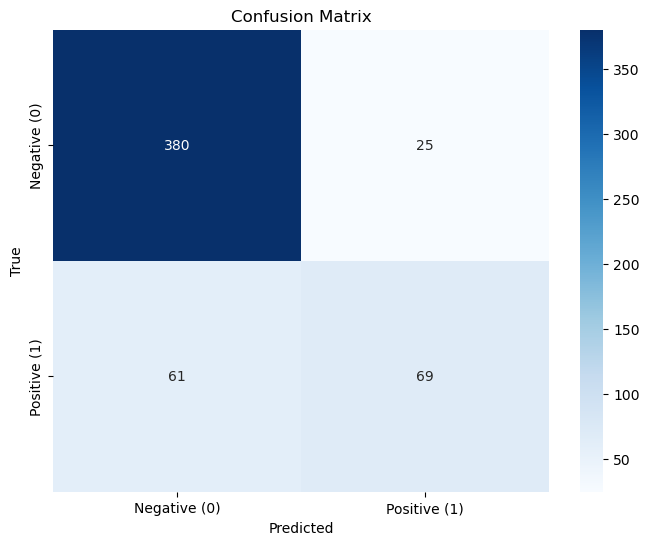

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = siec1.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [164]:
y_pred_prob

array([[0.06543193],
       [0.70195806],
       [0.20966493],
       [0.07186614],
       [0.05149763],
       [0.0535579 ],
       [0.03835782],
       [0.02118927],
       [0.10560951],
       [0.03213137],
       [0.9051518 ],
       [0.04593923],
       [0.1462763 ],
       [0.03517662],
       [0.09708474],
       [0.32956734],
       [0.43674752],
       [0.38841358],
       [0.05680833],
       [0.07358766],
       [0.3720325 ],
       [0.04519835],
       [0.06230516],
       [0.41810274],
       [0.39037812],
       [0.07998847],
       [0.04456156],
       [0.09870782],
       [0.21524689],
       [0.81649023],
       [0.05100013],
       [0.01437666],
       [0.04959053],
       [0.08033279],
       [0.07593225],
       [0.945162  ],
       [0.0837175 ],
       [0.16690962],
       [0.06666524],
       [0.89265984],
       [0.34619254],
       [0.37138516],
       [0.54049826],
       [0.14729342],
       [0.9805529 ],
       [0.02289621],
       [0.04941329],
       [0.400

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


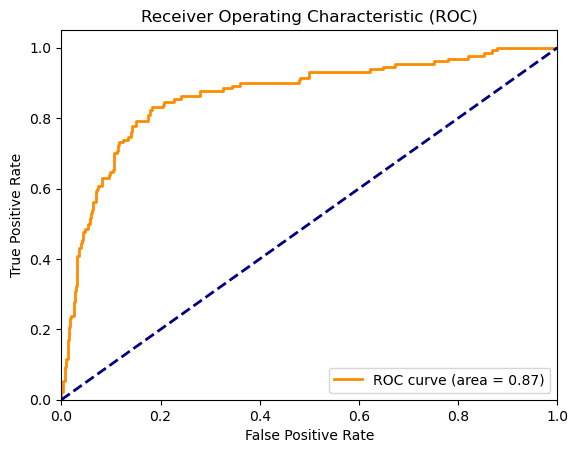

In [165]:
import matplotlib.pyplot as plt

y_pred_prob = siec1.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [166]:
y_pred_prob

array([[0.06543193],
       [0.70195806],
       [0.20966493],
       [0.07186614],
       [0.05149763],
       [0.0535579 ],
       [0.03835782],
       [0.02118927],
       [0.10560951],
       [0.03213137],
       [0.9051518 ],
       [0.04593923],
       [0.1462763 ],
       [0.03517662],
       [0.09708474],
       [0.32956734],
       [0.43674752],
       [0.38841358],
       [0.05680833],
       [0.07358766],
       [0.3720325 ],
       [0.04519835],
       [0.06230516],
       [0.41810274],
       [0.39037812],
       [0.07998847],
       [0.04456156],
       [0.09870782],
       [0.21524689],
       [0.81649023],
       [0.05100013],
       [0.01437666],
       [0.04959053],
       [0.08033279],
       [0.07593225],
       [0.945162  ],
       [0.0837175 ],
       [0.16690962],
       [0.06666524],
       [0.89265984],
       [0.34619254],
       [0.37138516],
       [0.54049826],
       [0.14729342],
       [0.9805529 ],
       [0.02289621],
       [0.04941329],
       [0.400

In [167]:
# Przygotowanie modelu sieci neuronowej z regularizacją i Dropout
siec2 = Sequential()
siec2.add(Dense(2, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
siec2.add(Dropout(0.2))
siec2.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
siec2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Wczesne zatrzymanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Uczenie modelu z walidacją
siec2.fit(X_train, y_train, epochs=100, batch_size=10, 
          validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6612 - loss: 0.7654 - val_accuracy: 0.6885 - val_loss: 0.6786
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7459 - loss: 0.6457 - val_accuracy: 0.7165 - val_loss: 0.6137
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.7606 - loss: 0.5967 - val_accuracy: 0.7352 - val_loss: 0.5663
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.7676 - loss: 0.5486 - val_accuracy: 0.7445 - val_loss: 0.5311
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.7731 - loss: 0.5254 - val_accuracy: 0.7477 - val_loss: 0.5053
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.7657 - loss: 0.5049 - val_accuracy: 0.7477 - val_loss: 0.4857
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.4842 - val_accuracy: 0.7508 - val_loss: 0.4695
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.7744 - loss: 0.4896 - val_accu

In [168]:
metrics(siec2)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
Accuracy: 0.8721945137157108
Confusion Matrix:
 [[1160   53]
 [ 152  239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1213
           1       0.82      0.61      0.70       391

    accuracy                           0.87      1604
   macro avg       0.85      0.78      0.81      1604
weighted avg       0.87      0.87      0.87      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
Accuracy: 0.8523364485981308
Confusion Matrix:
 [[385  20]
 [ 59  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       405
           1       0.78      0.55      0.64       130

    accuracy                           0.85       535
   macro avg    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


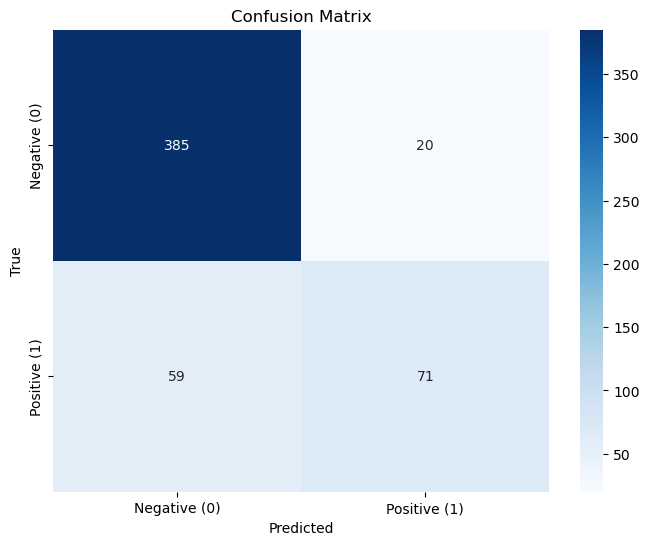

In [169]:
y_pred_prob = siec2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


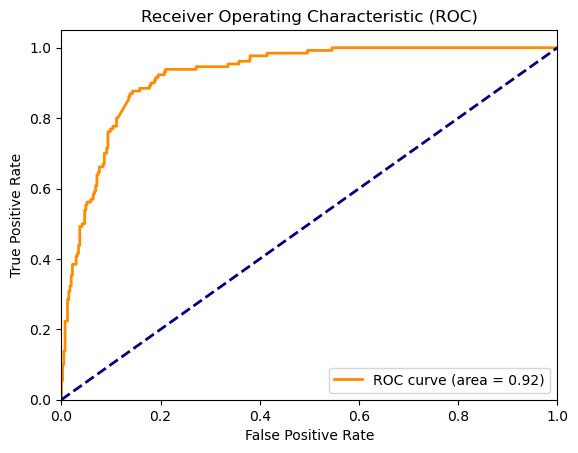

In [170]:
y_pred_prob = siec2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [171]:
# Przygotowanie bardziej złożonego modelu sieci neuronowej
siec3 = Sequential()
siec3.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
siec3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Wczesne zatrzymanie z bardziej elastycznymi ustawieniami
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Uczenie modelu z walidacją
siec3.fit(X_train, y_train, epochs=100, batch_size=32, 
          validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7598 - loss: 0.6496 - val_accuracy: 0.7539 - val_loss: 0.5409
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.5414 - val_accuracy: 0.8224 - val_loss: 0.4662
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8152 - loss: 0.4857 - val_accuracy: 0.8474 - val_loss: 0.4195
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8531 - loss: 0.4388 - val_accuracy: 0.8598 - val_loss: 0.3997
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.4367 - val_accuracy: 0.8660 - val_loss: 0.3908
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.4234 - val_accuracy: 0.8723 - val_loss: 0.3775
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.4175 - val_accuracy: 0.8816 - val_loss: 0.3645
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8617 - loss: 0.3992 - val_accuracy: 0.8847 - val_loss: 0.3

In [172]:
metrics(siec3)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9177057356608479
Confusion Matrix:
 [[1155   58]
 [  74  317]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1213
           1       0.85      0.81      0.83       391

    accuracy                           0.92      1604
   macro avg       0.89      0.88      0.89      1604
weighted avg       0.92      0.92      0.92      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.8878504672897196
Confusion Matrix:
 [[380  25]
 [ 35  95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       405
           1       0.79      0.73      0.76       130

    accuracy                           0.89       535
   macro avg       

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


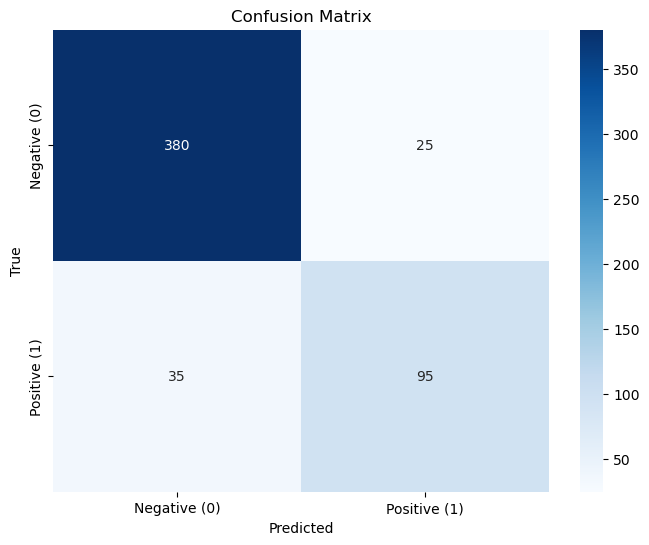

In [173]:
y_pred_prob = siec3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


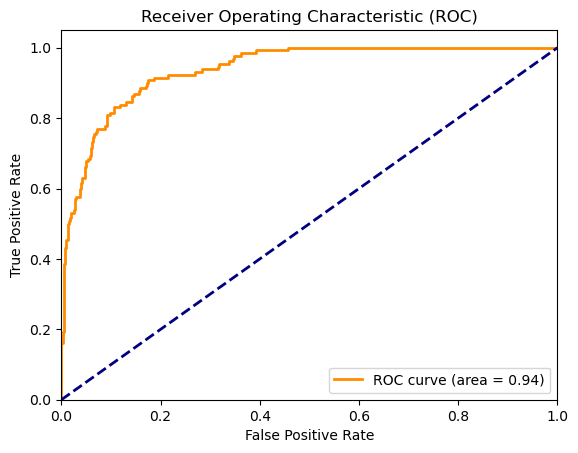

In [174]:
y_pred_prob = siec3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


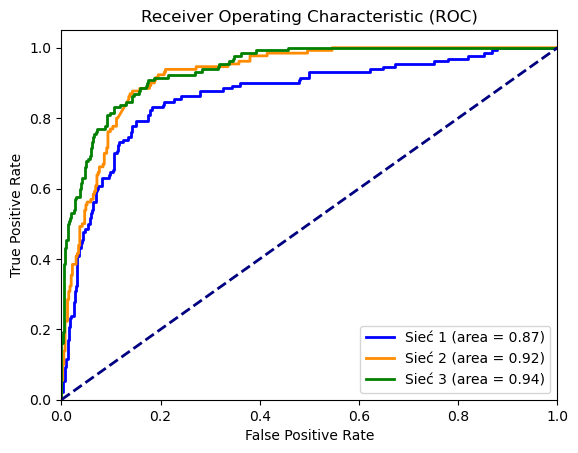

In [176]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predykcje prawdopodobieństw dla każdego modelu
y_pred_prob1 = siec1.predict(X_test)
y_pred_prob2 = siec2.predict(X_test)
y_pred_prob3 = siec3.predict(X_test)

# Obliczanie ROC AUC dla każdego modelu
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_pred_prob3)
roc_auc3 = auc(fpr3, tpr3)

# Rysowanie krzywych ROC dla wszystkich modeli na jednym wykresie
plt.figure()

plt.plot(fpr1, tpr1, color='blue', lw=2, label='Sieć 1 (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Sieć 2 (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='green', lw=2, label='Sieć 3 (area = %0.2f)' % roc_auc3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [178]:
models = {
    'siec1': {'neurons': 3, 'layers': 1, 'epochs': 50, 'model': siec1},
    'siec2': {'neurons': 2, 'layers': 1, 'epochs': 100, 'model': siec2},
    'siec3': {'neurons': 64, 'layers': 2, 'epochs': 100, 'model': siec3}
}

In [183]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
results = []

for name, info in models.items():
    model = info['model']
    model.fit(X_train, y_train, epochs=info['epochs'], verbose=0)  # Dopasowanie modelu
    y_pred_prob = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1
    y_pred = (y_pred_prob > 0.5).astype(int)  # Konwersja prawdopodobieństw na etykiety binarne
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    error_rate = 1 - accuracy
    results.append({
        'Model': name,
        'Neurony': info['neurons'],
        'Warstwy ukryte': info['layers'],
        'Epoki': info['epochs'],
        'AUC': auc,
        'Gini': gini,
        'Accuracy': accuracy,
        'F1-score': f1,
        'Error Rate': error_rate
    })

# Tworzenie DataFrame z wynikami
df = pd.DataFrame(results)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


In [184]:
df.head()

,Model,Neurony,Warstwy ukryte,Epoki,AUC,Gini,Accuracy,F1-score,Error Rate
0,siec1,3,1,50,0.872726,0.745451,0.846729,0.637168,0.153271
1,siec2,2,1,20,0.926239,0.852479,0.852336,0.632558,0.147664
2,siec3,2,1,15,0.937721,0.875442,0.878505,0.713656,0.121495
